In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
from collections import Counter
import numpy as np
from tqdm import tqdm
import random
from pymystem3 import Mystem
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

## Простая реализация Word2Vec

In [2]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, hidden_layer_size=512):
        super().__init__()
        self.vocab_size = vocab_size
        self.W1 = nn.Linear(vocab_size, hidden_layer_size)
        self.W2 = nn.Linear(hidden_layer_size, vocab_size)
    
    def forward(self, x):
        out = self.W2(self.W1(x))
        return out

## [`nn.Embedding`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

`nn.Embedding` - это, по сути, таблица (большая матрица), где каждая строка - это вектор, соответствующий одному слову из словаря. Когда подается индекс или несколько индексов в nn.Embedding, он просто возвращает строку (вектор) по этому индексу.

Под капотом `nn.Embedding` хранит одну матрицу весов размером `(num_embeddings, embedding_dim)`.

- `num_embeddings` — размер словаря. $\newline$

- `embedding_dim` — размерность вектора для каждого эмбеддинга. $\newline$

- `sparse` — флаг, определяющий, использовать разреженный (sparse) тензор градиентов или нет. 

### Как работает `nn.Embedding`?

Он работает таким образом, что берется тензор размера входного тензора и вместо его индексов подставляются строки из `nn.Embedding`. `nn.Embedding` сохраняет все измерения входного тензора и добавляет в конец еще одно измерение — размер эмбеддинга.

Пример: `nn.Embedding(5, 3)` — таблица с 5 словами, каждое представлено вектором размера 3. `torch.tensor([[1, 2], [2, 2]])` — входной тензор индексов формы `[2, 2]`.

Результатом будет тензор формы `[2, 2, 3]`.

- Берется первая строка входа: `[1, 2]` $\newline$

- Индекс 1 заменяется на `embedding[1]` (вектор размера 3). $\newline$

- Индекс 2 заменяется на `embedding[2]` (вектор размера 3). $\newline$

- Получается первая строка выхода: `[embedding[1], embedding[2]]`, которая имеет форму `[2, 3]`.

Аналогично для второй строки входа. В итоге форма `[2, 2]` превращается в `[2, 2, 3]`.

In [3]:
emb = nn.Embedding(5, 3)

In [4]:
emb(torch.tensor([[1, 2], [2, 2]])).shape

torch.Size([2, 2, 3])

In [5]:
emb(torch.tensor([1, 2])).shape

torch.Size([2, 3])

## Пример работы `nn.Embedding` в случае `sparse=False`

In [6]:
e = nn.Embedding(5, 5, sparse=False)

In [7]:
list(e.parameters())

[Parameter containing:
 tensor([[ 0.8003, -1.2953, -0.5549,  0.6236, -0.8836],
         [ 0.3760, -1.3419, -0.4892,  0.1682,  0.9191],
         [-0.9250, -1.0787, -0.9588, -0.9525, -1.3982],
         [-0.7965,  0.7856, -0.4581, -1.4727,  0.1010],
         [-0.0226, -0.5717,  1.0748, -0.4945,  1.0539]], requires_grad=True)]

In [8]:
e(torch.tensor([0, 1, 3])).sum().backward()

Когда `sparse=False`, PyTorch создает плотный тензор градиентов. Он имеет тот же размер, что и сама матрица весов (5, 5). Для тех векторов, которые использовались (индексы 0, 1, 3), градиенты посчитались. Для тех, которые не использовались (индексы 2, 4), градиенты просто равны нулю.

**Проблема:** Если словарь имеет 100,000 эмбеддингов, а в батче используется всего 256, то будет создаваться и храниться в памяти огромная матрица градиентов (100000, dim), 99% которой — нули. Это неэффективно.

In [9]:
list(e.parameters())[0].grad

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.]])

## Пример работы `nn.Embedding` в случае `sparse=True`

In [10]:
e = nn.Embedding(5, 5, sparse=True)

In [11]:
list(e.parameters())

[Parameter containing:
 tensor([[-0.0910,  0.2215,  0.5599, -2.3756,  1.0763],
         [-0.5346, -2.0156,  1.6321, -2.7524,  1.2127],
         [ 0.8098,  0.0481, -0.3063,  0.6027, -0.3584],
         [-0.0295,  1.1431, -0.8331,  0.5038, -0.7514],
         [-1.9020,  2.2420,  2.2237,  0.8407,  0.5247]], requires_grad=True)]

In [12]:
e(torch.tensor([0, 1, 3])).sum().backward()

Когда `sparse=True`, PyTorch создает разреженный (sparse) тензор градиентов. Вместо хранения всей матрицы с нулями, он хранит только:

- `indices` — индексы строк, для которых градиент не нулевой (в нашем случае это 0, 1, 3). $\newline$

- `values` — сами значения градиентов для этих строк. $\newline$

- `size` — общий размер "воображаемой" полной матрицы (5, 5).

In [13]:
list(e.parameters())[0].grad

tensor(indices=tensor([[0, 1, 3]]),
       values=tensor([[1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1.]]),
       size=(5, 5), nnz=3, layout=torch.sparse_coo)

**Примечание:** не все оптимизаторы PyTorch умеют работать с разреженными градиентами. `optim.Adam`, например, не умеет, а вот `optim.SGD` и `optim.SparseAdam` умеют.

## Модель `Word2Vec` (Skip-gram с Negative Sampling)

Идея `Word2Vec` такая:

Каждое слово имеет два векторных представления:

- Когда оно является центральным словом (из W1). $\newline$

- Когда оно является контекстным словом (из W2).

Мы хотим, чтобы скалярное произведение векторов "центральное слово - правильное контекстное слово" было большим (они похожи).

А скалярное произведение векторов "центральное слово - случайное 'негативное' слово" было маленьким (они не похожи).

In [14]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, hidden_layer_size=512):
        super().__init__()
        self.vocab_size = vocab_size
        self.W1 = nn.Embedding(vocab_size, hidden_layer_size, sparse=True)
        self.W2 = nn.Embedding(vocab_size, hidden_layer_size, sparse=True)
    
    def forward(self, input_indx, output_indx):
        out1 = self.W1(input_indx)  # [batch_size, 1, emb_dim]
        out2 = self.W2(output_indx)  # [batch_size, N, emb_dim]
        out2 = torch.transpose(out2, 1, 2)  # [batch_size, emb_dim, N]
        out = torch.bmm(out1, out2)  # [batch_size, 1, N]
        return out

In [15]:
RUSSIAN_STOPWORDS = {
    'а', 'бы', 'в', 'во', 'вы', 'где', 'для', 'до', 'его', 'ее', 'ему', 'если',
    'еще', 'же', 'за', 'и', 'из', 'или', 'их', 'к', 'как', 'когда', 'которые', 'я',
    'который', 'кроме', 'ли', 'мы', 'на', 'не', 'них', 'но', 'о', 'об', 'около',
    'он', 'она', 'они', 'от', 'по', 'под', 'при', 'с', 'свою', 'со', 'так', 'этом',
    'также', 'тем', 'то', 'того', 'только', 'том', 'у', 'чем', 'что', 'чтобы', 'это',
}

## `Word2VecDataset`

1. **Препроцессинг**: Если готовые токены не поданы, запускается метод preprocess.

    - Текст приводится к нижнему регистру. Удаляются все символы, кроме русских букв. $\newline$
      
    - Удаляются стоп-слова (частые, но не несущие смысла слова типа 'и', 'в', 'на'). $\newline$
  
    - Текст лемматизируется с помощью pymystem3 (слова приводятся к начальной форме: "бежал" -> "бежать"). Это сильно сокращает размер словаря. $\newline$
  
2. **Subsampling**.

   - `del_probs = {word: 1 - np.sqrt(subsampling_threshold / freq) ...}` $\newline$

   - Эта формула вычисляет вероятность удаления слишком частых слов. Частые слова встречаются повсюду и несут мало уникальной контекстной информации. Их удаление ускоряет обучение и улучшает качество векторов для более редких слов. $\newline$
  
3. **Создание словаря**. Если готовый словарь не подан:

   - Собирается `vocab_size` самых частых слов. Все остальные слова заменяются на специальный токен `<UNK>` (unknown). $\newline$
     
4. **Создание обучающих пар**.

   - Используя скользящее окно, для каждого слова в тексте мы смотрим на его соседей в пределах окна. $\newline$
     
   - `dynamic_window = np.random.randint(1, self.window_size + 1)`. Окно делается динамическим. Это трюк из оригинальной статьи Word2Vec, который придает больший вес словам, находящимся ближе к центральному, так как они в обучении будут встречаться чаще. $\newline$
  
   - `self.data.append((word_indx, context_indx))`. Каждая пара (центральное слово, контекстное слово) добавляется как один обучающий пример. $\newline$

5. **Подготовка к Negative Sampling**.

   - `word_freqs = word_freqs**0.75`. Частоты слов возводятся в степень 0.75. Это эвристика, которая сглаживает распределение: она понижает вероятность выбора очень частых слов и повышает вероятность выбора редких слов в качестве негативных примеров. $\newline$
  
   - `self.neg_sampling_weights`. На основе этих измененных частот создаются вероятности, которые будут использоваться для выбора "негативных" слов. $\newline$
  
6. **Получение одного элемента в `__getitem__`**.

   - Берется готовая пара `(target_word_indx, context_word_indx)` из `self.data`. $\newline$
  
   - `torch.multinomial(...)`. Генерирует `neg_samples` случайных индексов слов. Выбор происходит не равномерно, а в соответствии с весами `self.neg_sampling_weights`, которые мы подготовили ранее. Это и есть `Negative Sampling`. $\newline$
  
   - Возвращает три тензора: индекс целевого слова, индекс правильного контекстного слова и тензор с индексами неправильных (негативных) слов. 

In [16]:
class Word2VecDataset(Dataset):
    def __init__(self, text, vocab_size=None, window_size=5, neg_samples=5, vocab=None, tokens=None, subsampling_threshold=1e-5):
        self.mystem = Mystem()
        
        if tokens:
            self.tokens = tokens
        else:
            self.tokens = self.preprocess(text)
            
            word_counts_subsampling = Counter(self.tokens)
            total_words = len(self.tokens)
            word_freqs = {word: count / total_words for word, count in word_counts_subsampling.items()}
            del_probs = {word: 1 - np.sqrt(subsampling_threshold / freq) for word, freq in word_freqs.items() if freq > 0}
    
            self.tokens = [word for word in self.tokens if np.random.rand() > del_probs.get(word, 0)]
        
        word_counts = Counter(self.tokens)
        if vocab:
            self.vocab = vocab
        else:
            if vocab_size:
                self.vocab = [word for word, _ in word_counts.most_common(vocab_size - 1)] + ["<UNK>"]
            else:
                self.vocab = list(word_counts.keys())
            
        word_to_idx = {word:i for i, word in enumerate(self.vocab)}
        idx_to_word = {i:word for i, word in enumerate(self.vocab)}
        
        self.vocab_size = len(self.vocab)
        self.token_indices = [word_to_idx.get(word, self.vocab_size - 1) for word in self.tokens]
        self.window_size = window_size
        
        self.regenerate_data()
                
        word_freqs = np.array([word_counts[word] for word in self.vocab])
        word_freqs = word_freqs**0.75
        self.neg_sampling_weights = torch.from_numpy(word_freqs / np.sum(word_freqs))
        self.neg_samples = neg_samples
            
    def preprocess(self, text):
        text = text.lower()
        chunks = text.split('\n')
        lemmatized_tokens = []
        for chunk in tqdm(chunks):
            if not chunk.strip():
                continue
                
            cleaned_chunk = re.sub(r'[^а-яА-ЯёЁ]+', ' ', chunk)
            words = cleaned_chunk.split()
            filtered_words = [word for word in words if word not in RUSSIAN_STOPWORDS]
            pre_lemmatized_text = ' '.join(filtered_words)
            
            if not pre_lemmatized_text.strip():
                continue
                
            processed_chunk = self.mystem.lemmatize(pre_lemmatized_text)
            final_tokens = [token for token in processed_chunk if token.strip()]
            lemmatized_tokens.extend(final_tokens)
            
        return lemmatized_tokens    

    def regenerate_data(self):
        self.data = []
        for i, word_indx in tqdm(enumerate(self.token_indices)):
            dynamic_window = np.random.randint(1, self.window_size + 1)
            start = max(0, i - dynamic_window)
            end = min(len(self.token_indices), i + dynamic_window + 1)
            for j in range(start, end):
                if i == j:
                    continue
                context_indx = self.token_indices[j]
                self.data.append((word_indx, context_indx))
    
    def __getitem__(self, indx):
        target_word_indx, context_word_indx = self.data[indx]
        neg_samples = torch.multinomial(
            self.neg_sampling_weights, self.neg_samples, replacement=True
        )
        
        return torch.tensor(target_word_indx), torch.tensor(context_word_indx), neg_samples
    
    def __len__(self):
        return len(self.data)

In [17]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

In [18]:
dataset_path = "/kaggle/input/lenta-text-dataset/lenta.txt"
text = open(dataset_path, encoding="utf-8").read()
txt = text[:int(len(text) / 8)]

In [19]:
with open("/kaggle/input/tokens-word2vec/tokens_word2vec.txt", "r") as f:
    tokens = f.read().split()

In [20]:
len(tokens)

4191204

In [21]:
with open("/kaggle/input/vocab-word2vec/vocab_word2vec.txt", "r") as f:
    vocab = f.read().split()

In [22]:
len(vocab)

100000

In [23]:
num_neg_samples = 5

In [24]:
dataset = Word2VecDataset(txt, vocab_size=100000, tokens=tokens, vocab=vocab, neg_samples=num_neg_samples)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
4191204it [00:36, 114968.59it/s]


In [25]:
main_vocab = dataset.vocab

In [26]:
len(main_vocab)

100000

In [27]:
len(dataset.tokens)

4191204

In [28]:
target_word, context_word, neg_samples = dataset[500]

In [29]:
target_word, context_word, neg_samples

(tensor(886), tensor(17853), tensor([ 288,  318,  777,  253, 7638]))

In [30]:
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True, num_workers=2)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [34]:
model = Word2Vec(dataset.vocab_size, 128).to(device)

In [35]:
optimizer = optim.SparseAdam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(5):
    total_loss = 0
    progress_bar = tqdm(dataloader,
                        leave=False,
                        unit="batch")
    running_loss = 0
    m = 0
    
    for target_words, context_words, neg_samples in progress_bar:
        target_words = target_words.unsqueeze(1).to(device)
        context = torch.cat([context_words.unsqueeze(1), neg_samples], dim=1).to(device)
        
        scores = model(target_words, context)
        scores = scores.squeeze(1)
        
        labels = torch.cat([
            torch.ones(context.size(0), 1), 
            torch.zeros(context.size(0), num_neg_samples)
        ], dim=1).to(device)
        
        loss = criterion(scores, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        value = loss.item()
        m += 1
        running_loss = 1/m * value + (1 - 1/m) * running_loss
        text = f"Epoch = {epoch+1}; Loss = {running_loss:.3f};"
        progress_bar.set_description(text)

    torch.save(model.state_dict(), f"{epoch+1}_loss_{running_loss:.3f}.pth")

Epoch = 1; Loss = 3.612;:  89%|████████▉ | 35320/39486 [30:03<03:41, 18.80batch/s]

In [40]:
running_loss

1.220373119438551

In [36]:
weight = "/kaggle/input/word2vec_model/pytorch/default/17/8_loss_0.296.pth"
model.load_state_dict(torch.load(weight, weights_only=True, map_location=device))

<All keys matched successfully>

In [37]:
model

Word2Vec(
  (W1): Embedding(100000, 128, sparse=True)
  (W2): Embedding(100000, 128, sparse=True)
)

In [38]:
def get_embeddings(model, dataset):
    embeddings = model.W1.weight.cpu().data.numpy()
    word_to_idx = {word:i for i, word in enumerate(dataset.vocab)}
    word_vectors = {word: embeddings[i] for word, i in word_to_idx.items()}
    return word_vectors

In [39]:
word_vectors = get_embeddings(model, dataset)

In [77]:
def most_similar(word, word_vectors, topn=10):
    if word not in word_vectors:
        raise ValueError(f"Слово '{word}' не найдено в словаре")

    emb1 = word_vectors[word]
    sims = {}
    for other_word, emb2 in word_vectors.items():
        if other_word == word:
            continue
        res = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        sim = np.arccos(res) * 180 / np.pi
        sims[other_word] = round(sim, 3)

    nearest = sorted(sims.items(), key=lambda x: x[1], reverse=False)[:topn]
    return nearest

In [89]:
words = ["интернет", "матч", "машина", "солнце", "армия", "море", "бизнес", "конституция", "поезд"]

In [90]:
df = pd.DataFrame()
for word in words:
    nearest_similar = dict(most_similar(word, word_vectors, topn=10))
    df[f"Слово {word.upper()}"] = nearest_similar.keys()

### Самые близкие по косинусной близости слова. Используются слова:

### `интернет, матч, машина, солнце, армия, море, бизнес, конституция, поезд`

In [91]:
df

,Слово ИНТЕРНЕТ,Слово МАТЧ,Слово МАШИНА,Слово СОЛНЦЕ,Слово АРМИЯ,Слово МОРЕ,Слово БИЗНЕС,Слово КОНСТИТУЦИЯ,Слово ПОЕЗД
0,пользователь,сборная,автомобиль,планета,военный,судно,компания,конституционный,вагон
1,сеть,команда,водитель,солнечный,войско,затонуть,ведомость,принятие,железнодорожный
2,электронный,обыгрывать,грузовик,марс,солдат,дно,финансовый,парламентарий,рельс
3,программный,игрок,происшествие,ученый,командование,лодка,инвестиционный,парламент,пассажирский
4,доступ,чемпионат,рядом,земля,военнослужащий,морской,инвестор,референдум,дорога
5,компьютерный,лига,пострадать,атмосфера,оборона,подводный,деловой,закон,пассажир
6,сетевой,финал,автомашина,поверхность,вооруженный,побережье,продажа,парламентский,грузовик
7,пользоваться,переигрывать,легковой,снимок,подразделение,подымать,капитал,голосование,транспортный
8,например,игра,врезаться,земной,сила,спасательный,сделка,законодательство,остановка
9,сервер,забивать,ранение,орбита,армейский,моряк,покупка,вносить,железный


In [104]:
def nearest_embeddings(word, word_vectors, topn=15):
    nearest_similar = most_similar(word, word_vectors, topn=topn)
    items = [word]
    for it in nearest_similar:
        items.append(it[0])
    vec = []
    for it in items:
        vec.append(word_vectors[it].copy())
    vec = np.array(vec)
    return vec

In [105]:
imp_emb = []
classes = []
for i, word in enumerate(words):
    v = nearest_embeddings(word, word_vectors, topn=10)
    classes.extend([i] * v.shape[0])
    imp_emb.append(v)
vec = np.concatenate(imp_emb, axis=0)

In [106]:
v = np.array(list(word_vectors.values()))
indx = np.random.choice(v.shape[0], size=10000, replace=False)
vector = np.concatenate([vec, v[indx, :]], axis=0)

In [107]:
vector.shape

(10099, 128)

In [108]:
tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=30)
xy_tsne = tsne.fit_transform(vector) 
xy = xy_tsne[:len(words)*11]
xy_other = xy_tsne[len(words)*11:]

## Визуализация эмбеддингов с помощью алгоритма t-SNE, отдельная точка на графике соответствует отдельному уникальному слову.

- **Цветами выделены слово и ближайшие к ней по косинусной близости слова.** $\newline$

- **Видно, что кластер, который соответствует слову "машина", также совпадает с кластером, который соответствует слову "поезд", что логично.** $\newline$

- **Также кластер, который соответствует слову "интернет", близок к кластеру, который соответствует слову "бизнес".**

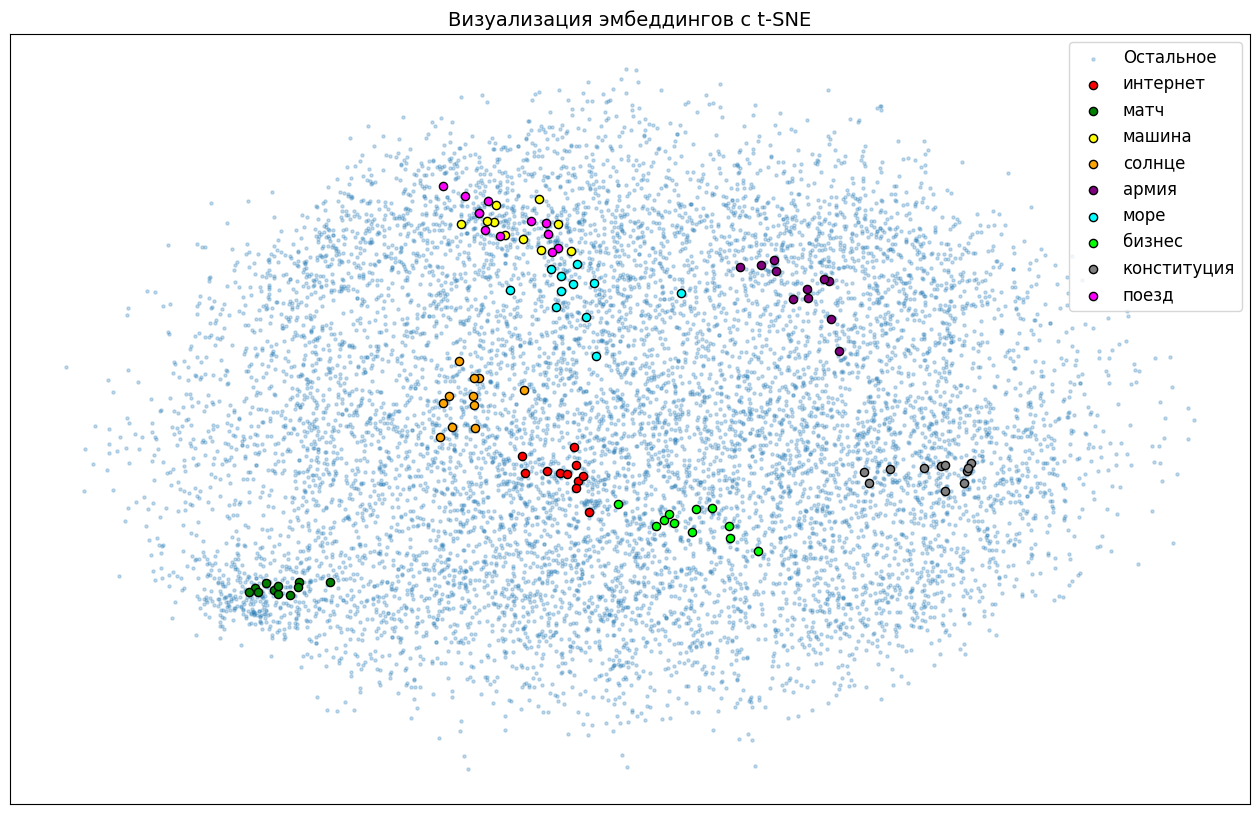

In [259]:
plt.figure(figsize=(16, 10))
plt.scatter(xy_other[:, 0], xy_other[:, 1], s=20, label="Остальное", alpha=0.25, marker='.')
colors = ["red", "green", "yellow", "orange", "purple", "cyan", "lime", "grey", "magenta"]
for i, word in enumerate(words):
    color = colors[i]
    plt.scatter(xy[i*11:(i+1)*11, 0], xy[i*11:(i+1)*11, 1], s=35, label=word, edgecolors="black", color=color)
plt.legend(fontsize='large')
plt.title("Визуализация эмбеддингов с t-SNE", fontsize=14)
plt.xticks([]) 
plt.yticks([]);